<img src="CO2_image_header.jpeg" style="width: 100%; height: auto; display: block; margin-left: auto; margin-right: auto;">

# <p style="background-color: rgba(255, 255, 255, 0.7); padding: 20px; text-align: center; color: DarkBlue; font-size: 38px;">**Insights on CO2 emissions**</p>

**An analysis of emissions by country: in metric tons of CO2 emissions per capita**

**Over time: from 1990 to 2021**

<span style="color:Red">**And the biggest contributors**</span>

In [30]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, Dropdown
from IPython.display import display, HTML
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

import warnings
warnings.filterwarnings('ignore')

In [31]:
co2_production_country = pd.read_csv('Data/co2_production.csv')

#co2_production_country.head()


#dataset overview ~ Data cleaning, pre-processing

#co2_production_country.info()


#checking for duplicates  ~ Data cleaning, pre-processing

#co2_production_country.duplicated().any()


#checking for NaNs  ~ Data cleaning, pre-processing

#co2_production_country.isna().sum()


#better understanding the NaNs ~ Data cleaning, pre-processing

#co2_production_country[co2_production_country.isna().any(axis=1)].head(35)


#Now I'm trying to find a way to fill in the NaN regions with the correct values. Found two files online that can help. ~ Data cleaning, pre-processing

country_regions = pd.read_csv('Data/CLASS.csv')
regions_codes = pd.read_csv('Data/data-verbose.csv')

#country_regions.head()

#regions_codes.head()


#merging the datasets ~ Data cleaning, pre-processing

region_to_code = regions_codes.set_index('WORLDBANKREGION')['Code'].to_dict()

country_regions['Region code'] = country_regions['Region'].map(region_to_code)

#country_regions.head()


#Replacing the NaNs with the region codes ~ Data cleaning, pre-processing

countrycode_to_regioncode = dict(zip(country_regions['Code'], country_regions['Region code']))

co2_production_country['region'] = co2_production_country['ISO3'].map(countrycode_to_regioncode).combine_first(co2_production_country['region'])

#co2_production_country['region'].isna().sum()


#co2_production_country[co2_production_country['region'].isna()]


#checking rows with too many NaNs that might be deleted ~ Data cleaning, pre-processing

nan_counts = co2_production_country.isna().sum(axis=1)

#co2_production_country[nan_counts >= 5]


#deleting 2 countries with no data ~ Data cleaning, pre-processing

countries_to_drop = ['Monaco', 'San Marino']

co2_production_country = co2_production_country[~co2_production_country['Country'].isin(countries_to_drop)]

#co2_production_country[nan_counts >= 5]


# checking NaNs on hdi columns ~ Data cleaning, pre-processing

#co2_production_country[co2_production_country['hdicode'].isna()]


# Nauru, North Korea and Somalia were not included in 2021's Human Development Index dataset due to a lack of sufficient reliable data from those countries. So for the purposes of this analysis I'll place them in the last 3 positions and add the hdi code as low ~ Data cleaning, pre-processing

co2_production_country['hdi_rank_2021'] = co2_production_country['hdi_rank_2021'].astype(float).astype(pd.Int64Dtype(), errors='ignore')

max_position = co2_production_country['hdi_rank_2021'].max()

last_3_positions = list(range(max_position + 1, max_position + 4))

fill_values = {index: value for index, value in zip(co2_production_country[co2_production_country['hdi_rank_2021'].isna()].index, last_3_positions)}

co2_production_country['hdi_rank_2021'] = co2_production_country['hdi_rank_2021'].fillna(fill_values)

#co2_production_country[co2_production_country['hdicode'].isna()]



#co2_production_country.hdicode.unique()
co2_production_country['hdicode'] = co2_production_country['hdicode'].fillna('Low')

#co2_production_country.hdicode.unique()


#checking NaNs in the co2_prod columns ~ Data cleaning, pre-processing

#co2_production_country[nan_counts >= 2]


# Melting dataset so I can fill in the missing values with the same trend/pattern/behaviours of the years I do have data for each country ~ Data cleaning, pre-processing


id_vars = ['ISO3', 'Country', 'hdicode', 'region', 'hdi_rank_2021']

melted_co2_production_country = pd.melt(co2_production_country, id_vars=id_vars, var_name='co2_prod_year', value_name='co2_prod').sort_values('Country')

#melted_co2_production_country

melted_co2_production_country['co2_prod_year'] = melted_co2_production_country['co2_prod_year'].str.replace('co2_prod_', '')


melted_co2_production_country['co2_prod_year'] = pd.to_numeric(melted_co2_production_country['co2_prod_year'], errors='coerce')


melted_co2_production_country = melted_co2_production_country.sort_values(by=['Country', 'co2_prod_year']).reset_index(drop=True)

#melted_co2_production_country

#melted_co2_production_country.info()

#melted_co2_production_country.head()

In [32]:
# Now,as mentioned above, I want to replace the nan values of the CO2_prod column with the values by following the same trend of the other years(for the same country) ~ Data cleaning, pre-processing

# Converting 'co2_prod_year' to float
melted_co2_production_country['co2_prod_year'] = melted_co2_production_country['co2_prod_year'].astype(float)

# Getting the current minimum value of 'co2_prod'
min_co2 = melted_co2_production_country['co2_prod'].min()

# Defining a custom interpolation function
def interpolate_and_fillna(group):
    interpolated_values = group.interpolate(method='spline', order=1, limit_direction='backward', limit_area=None)
    filled_values = interpolated_values.fillna(method='bfill').fillna(method='ffill')
    # Enforce a minimum value for 'co2_prod' based on the current minimum value in the dataset
    filled_values = filled_values.clip(lower=min_co2)
    return filled_values

# Appling the custom function using transform
melted_co2_production_country['co2_prod'] = melted_co2_production_country.groupby('ISO3')['co2_prod'].transform(interpolate_and_fillna)

# Reseting index after transform
melted_co2_production_country = melted_co2_production_country.reset_index(drop=True)


# Taking an example to check if it worked

#melted_co2_production_country[melted_co2_production_country['ISO3'] == 'FSM']


melted_co2_production_country['co2_prod_year'] = melted_co2_production_country['co2_prod_year'].astype('int64')

#melted_co2_production_country.info()

## Overview - Global

In [33]:
#better understanding the data ~ Data analysis

#melted_co2_production_country.describe()

On average we emit <span style="color:Red">**4.5 metric tons of CO2 per capita**</span>, per year. To put this into perspective to meet the Paris Agreement goal of limiting global warming to 1.5°C, we should emit less than <span style="color:ForestGreen">**2.3 tons of CO2 per person every year**</span>.

Although this is the average considering 30 years, you can see below that it stayed basically the same over the different decades.

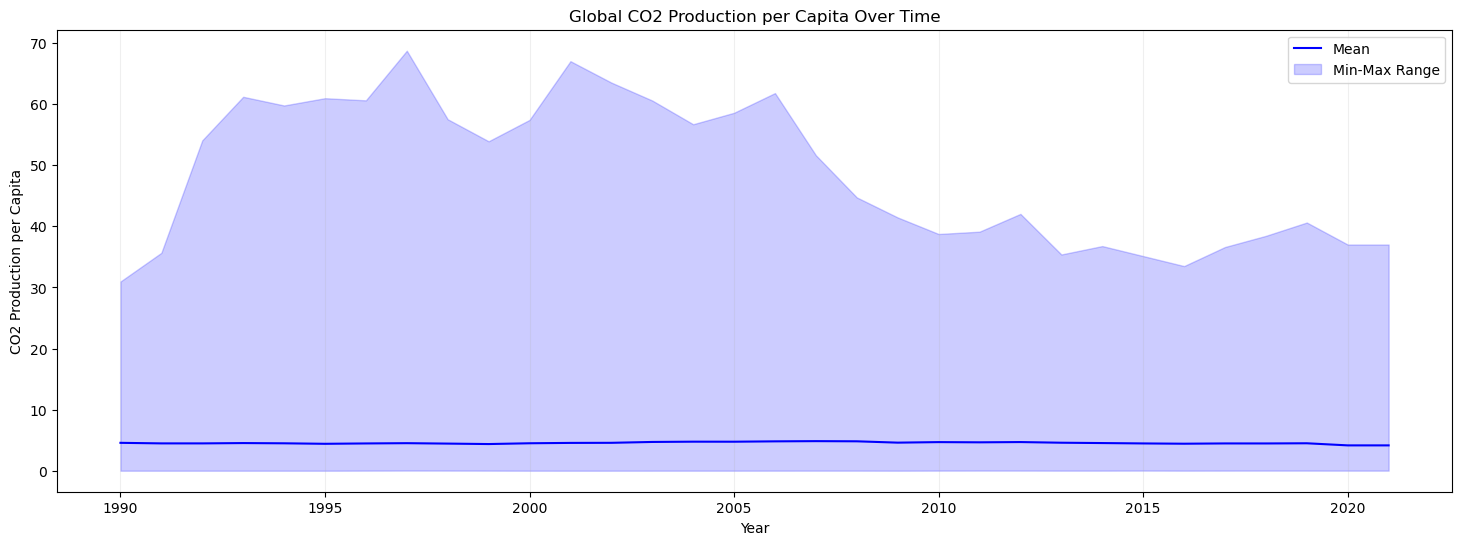

In [34]:


# Calculate mean, min, and max values for CO2 production per capita per year
global_emissions = melted_co2_production_country.groupby('co2_prod_year')['co2_prod'].agg(['mean', 'min', 'max']).reset_index()

# Plotting the time series graph with shaded error bands
plt.figure(figsize=(18, 6))

# Plot the mean line
plt.plot(global_emissions['co2_prod_year'], global_emissions['mean'], label='Mean', color='blue')

# Fill the area between min and max as a shaded error band
plt.fill_between(global_emissions['co2_prod_year'], global_emissions['min'], global_emissions['max'], color='blue', alpha=0.2, label='Min-Max Range')

# Customize the plot
plt.title('Global CO2 Production per Capita Over Time')
plt.xlabel('Year')
plt.ylabel('CO2 Production per Capita')
plt.legend()
plt.grid(axis='x', alpha=0.2)

# Show the plot
plt.show()


However, the emissions are not evenly distributed, with some countries emitting a lot more than the rest

From the boxplot below we can see that **half of the analysed countries(193) already meet the 2.3 target emissions**

While the **top 25%** releases between 3x and 29xthe recommended amount


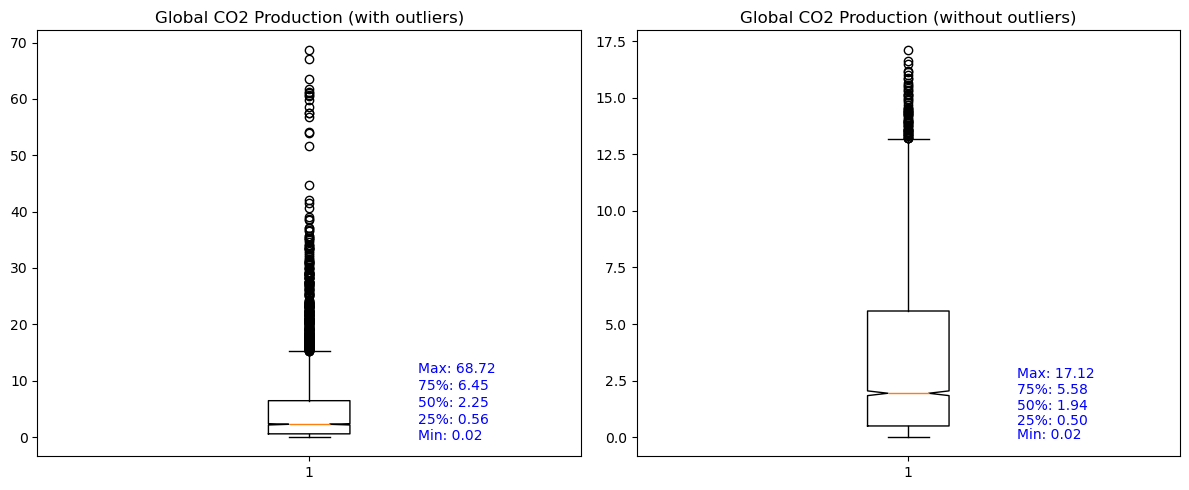

In [35]:

# Group data by year
grouped_by_year = melted_co2_production_country.groupby('co2_prod_year')['co2_prod']

# Identify and remove outliers for each year
df_no_outliers = pd.DataFrame()

for year, group in grouped_by_year:
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1

    # Define the upper and lower bounds to identify outliers for each year
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out outliers for each year
    df_no_outliers = pd.concat([df_no_outliers, group[(group >= lower_bound) & (group <= upper_bound)]])

# Reset index to make sure it's numeric
df_no_outliers.reset_index(drop=True, inplace=True)

# Plot the original data and outliers
plt.figure(figsize=(12, 5))

# Boxplot of CO2 Production (with outliers)
plt.subplot(1, 2, 1)
plt.boxplot(melted_co2_production_country['co2_prod'], notch=True, vert=True)
plt.title('Global CO2 Production (with outliers)')

# Boxplot of CO2 Production (without outliers)
plt.subplot(1, 2, 2)
plt.boxplot(df_no_outliers, notch=True, vert=True)
plt.title('Global CO2 Production (without outliers)')

# Add legends
plt.subplot(1, 2, 1)
plt.text(1.2, 0.1, f'Min: {melted_co2_production_country["co2_prod"].min():.2f}', ha='left', va='center', color='blue')
plt.text(1.2, 3, f'25%: {melted_co2_production_country["co2_prod"].quantile(0.25):.2f}', ha='left', va='center', color='blue')
plt.text(1.2, 6, f'50%: {melted_co2_production_country["co2_prod"].median():.2f}', ha='left', va='center', color='blue')
plt.text(1.2, 9, f'75%: {melted_co2_production_country["co2_prod"].quantile(0.75):.2f}', ha='left', va='center', color='blue')
plt.text(1.2, 12, f'Max: {melted_co2_production_country["co2_prod"].max():.2f}', ha='left', va='center', color='blue')

plt.subplot(1, 2, 2)
plt.text(1.2, 0.1, f'Min: {df_no_outliers.min().values[0]:.2f}', ha='left', va='center', color='blue')
plt.text(1.2, 0.7, f'25%: {df_no_outliers.quantile(0.25).values[0]:.2f}', ha='left', va='center', color='blue')
plt.text(1.2, 1.4, f'50%: {df_no_outliers.median().values[0]:.2f}', ha='left', va='center', color='blue')
plt.text(1.2, 2.1, f'75%: {df_no_outliers.quantile(0.75).values[0]:.2f}', ha='left', va='center', color='blue')
plt.text(1.2, 2.8, f'Max: {df_no_outliers.max().values[0]:.2f}', ha='left', va='center', color='blue')

# Adjust layout
plt.tight_layout()
plt.show()


To better understand how the emissions are distributed in terms of countries we can take a look at the map below.

Over the decades we can see that the countries that generate the most CO2 remain similar, and some regions/countries catch our attention, such as:
North America, Australia, Russia, Middle East...

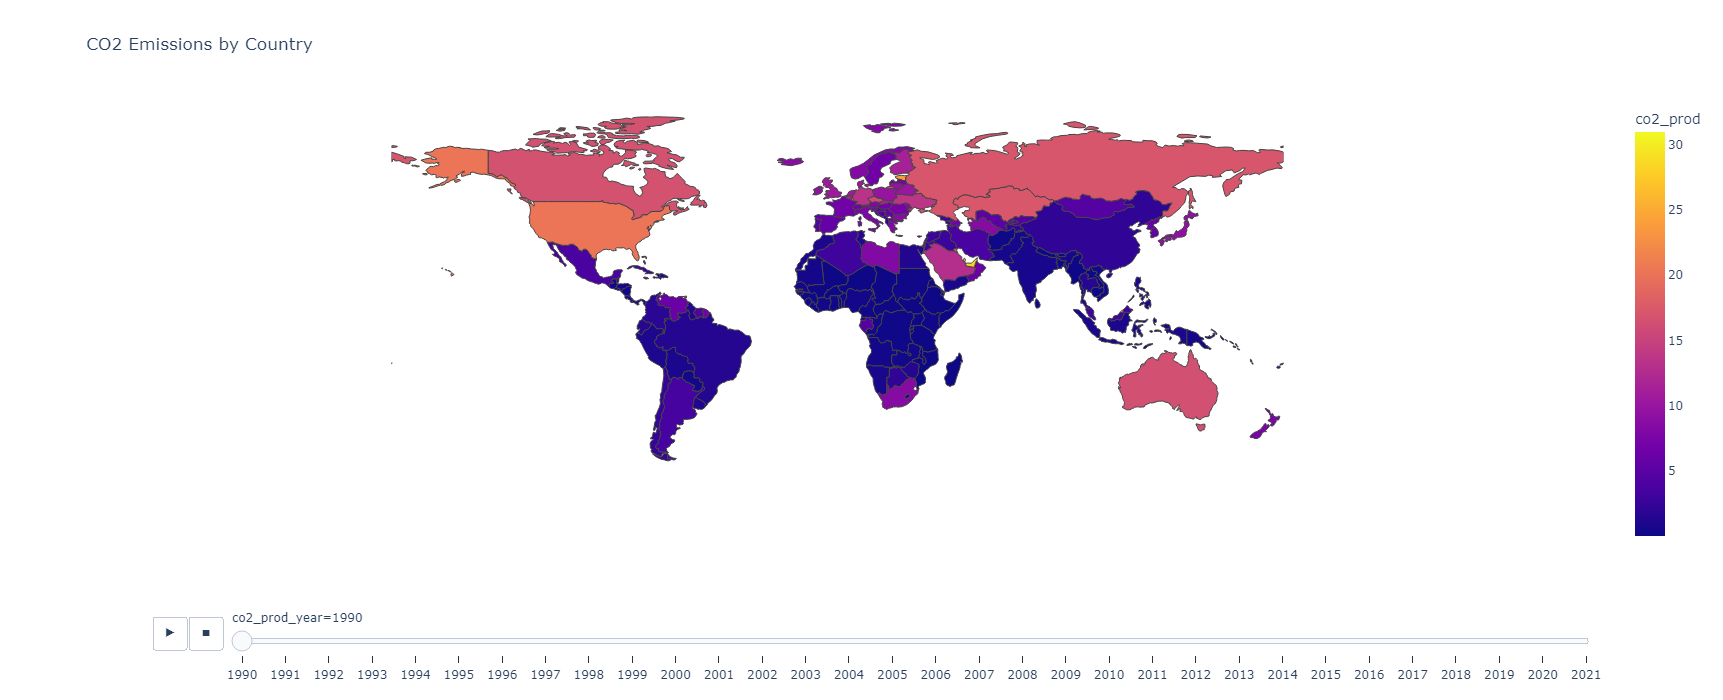

In [36]:

fig = px.choropleth(melted_co2_production_country,
                    locations='Country',
                    locationmode='country names',
                    color='co2_prod',
                    hover_name='Country',
                    animation_frame='co2_prod_year',
                    title='CO2 Emissions by Country',
                    color_continuous_scale=px.colors.sequential.Plasma)

fig.update_geos(projection_scale=1, visible=False)
fig.update_layout(height=700, width=1100)

fig.show()


## Overview - Regions and HDI

Here we can see that on average North America releases the most CO2 per capita on average, followed by Middle East & North Africa, and in 3rd position we have Europe & Central Asia.

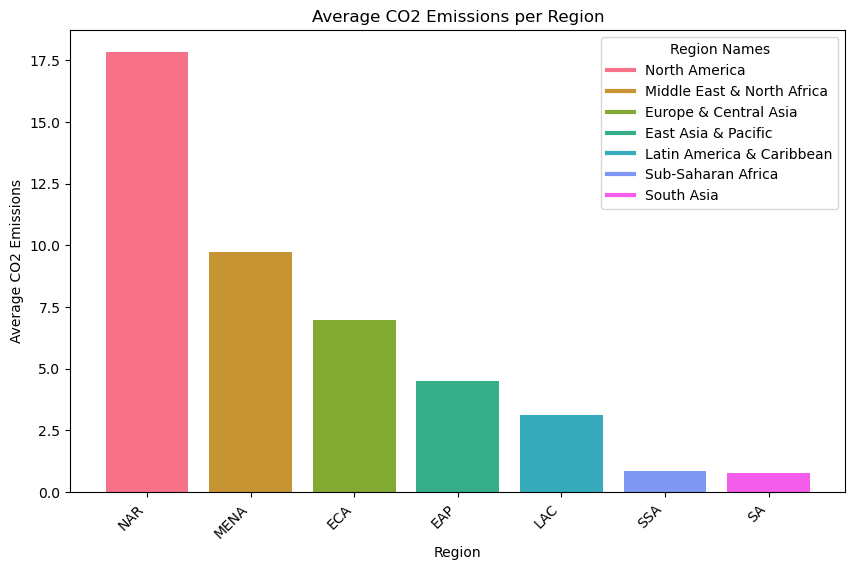

In [37]:

# Merge the melted_co2_production_country dataset with the regions_codes dataset
merged_data = melted_co2_production_country.merge(regions_codes, left_on='region', right_on='Code', how='left')

# Group by region and calculate the average CO2 emissions
avg_co2_by_region = merged_data.groupby('region')['co2_prod'].mean().reset_index()
avg_co2_by_region = avg_co2_by_region.sort_values(by='co2_prod', ascending=False)
for_legend = merged_data.groupby('WORLDBANKREGION')['co2_prod'].mean().reset_index()
for_legend = for_legend.sort_values(by='co2_prod', ascending=False)

# Plotting the bar plot
region_palette = sns.color_palette("husl", n_colors=len(avg_co2_by_region['region']))
plt.figure(figsize=(10, 6))

bars = plt.bar(avg_co2_by_region['region'], avg_co2_by_region['co2_prod'], color=region_palette)

# Create a custom legend using the region_names from the dataset
legend_labels = [plt.Line2D([0], [0], color=color, linewidth=3, linestyle='-') for color in region_palette]
plt.legend(legend_labels, for_legend['WORLDBANKREGION'], title='Region Names', loc='upper right')

plt.xlabel('Region')
plt.ylabel('Average CO2 Emissions')
plt.title('Average CO2 Emissions per Region')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

# Show the plot
plt.show()

When we analyse the emissions over time, we can see that **North America** was always on top, but has been slowly reducing the CO2 released

While **Middle East & North Africa** and **Europe & Central Asia** exchanged positions, and also have been reducing the emissions per capita

**East Asia & Pacific** have been increasing this gas production in the last years

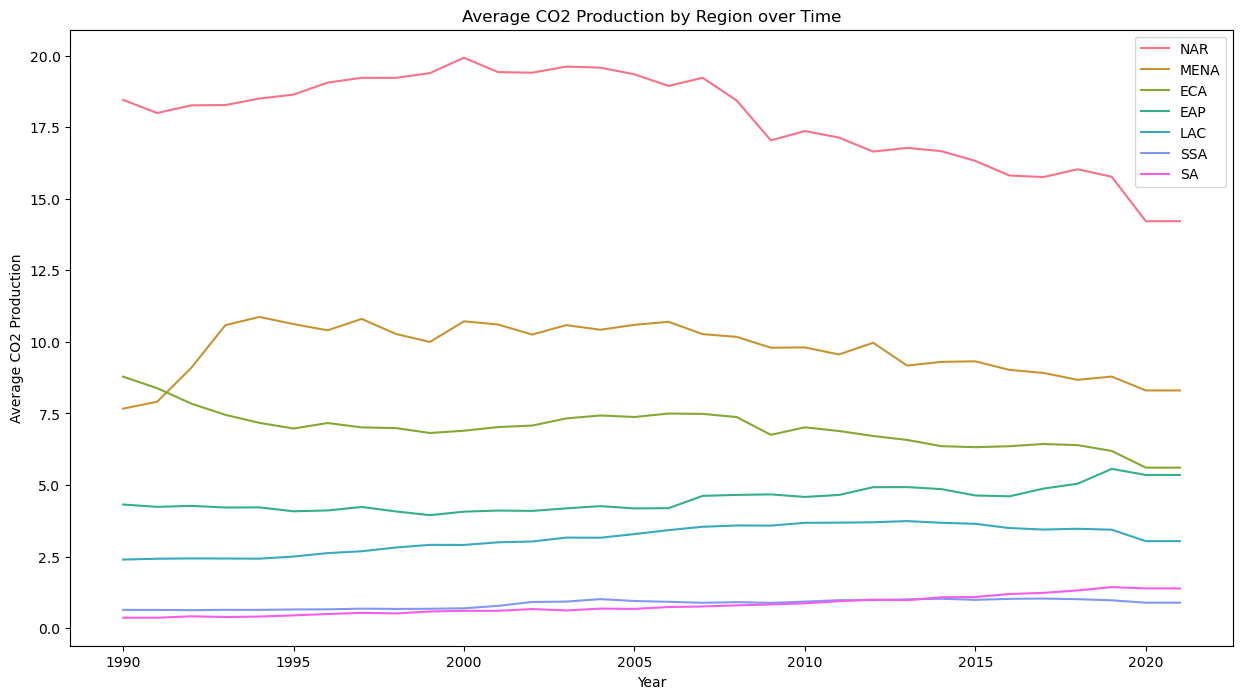

In [38]:

avg_production_per_region_year = melted_co2_production_country.groupby(['region', 'co2_prod_year'])['co2_prod'].mean().reset_index()
avg_production_per_region_year.head()

# Plotting time series graph
plt.figure(figsize=(15, 8))

# Specify the order of regions for both plots
region_order = avg_co2_by_region['region'].tolist()

# Iterate over regions in the specified order and plot the time series graph for each
for i, region in enumerate(region_order):
    region_data = avg_production_per_region_year[avg_production_per_region_year['region'] == region]
    plt.plot(region_data['co2_prod_year'], region_data['co2_prod'], label=region, color=region_palette[i])
    
# Customizing plot
plt.xlabel('Year')
plt.ylabel('Average CO2 Production')
plt.title('Average CO2 Production by Region over Time')
plt.legend()
plt.show()


Below we can see that over the decades, the countries with very high human development index emit more CO2 per capita.

However, there are some exceptions.

In [39]:

# Step 1: Divide the data into decades
def create_decades(data):
    decades = {}
    for year in range(1990, 2022, 10):
        decade_data = data[(data['co2_prod_year'] >= year) & (data['co2_prod_year'] < year + 10)]
        decades[f"{year}s"] = decade_data
    return decades

# Step 2: Create an interactive scatterplot
def plot_scatterplot(selected_decade):
    selected_data = decades[selected_decade]
    fig = px.scatter(selected_data, x='hdi_rank_2021', y='co2_prod', color='hdicode',
                     color_discrete_map={'High': 'blue', 'Low': 'red', 'Medium': 'green'},
                     title=f"CO2 Production vs HDI Rank ({selected_decade})",
                     labels={'hdi_rank_2021': 'HDI Rank', 'co2_prod': 'CO2 Production'},
                     hover_name='Country')
    fig.update_layout(height=600)
    fig.show()

# Step 3: Create a dropdown widget to select the decade
decades = create_decades(melted_co2_production_country)
decade_options = list(decades.keys())
dropdown_decade = widgets.Dropdown(options=decade_options, description='Decade:', disabled=False)

# Display the interactive scatterplot
interactive_plot = widgets.interactive(plot_scatterplot, selected_decade=dropdown_decade)
display(interactive_plot)

interactive(children=(Dropdown(description='Decade:', options=('1990s', '2000s', '2010s', '2020s'), value='199…

## Overview - Countries

Below we can see the top and bottom countries over the years, decades and all time.

Note that the tables with the top 10 countries for 1990 and for 2021 have 6 names in common.

And that the decade with the higher average emission per country per capita is the 1990s with Qatar at 48.4 metric tons.

In [40]:

@interact
def show_top_producers(
    year=widgets.Dropdown(options=['All'] + list(melted_co2_production_country['co2_prod_year'].unique()), description='Year:'),
    decade=widgets.Dropdown(options=['All'] + list(melted_co2_production_country['co2_prod_year'].astype(str).str[:3].unique()), description='Decade:'),
    all_time=widgets.ToggleButton(value=False, description='All Time:')
):
    if year != 'All':
        data = melted_co2_production_country[melted_co2_production_country['co2_prod_year'] == year]
    elif decade != 'All':
        years_in_decade = [str(y) for y in range(int(decade), int(decade) + 10)]
        data = melted_co2_production_country[melted_co2_production_country['co2_prod_year'].astype(str).str[:3].isin(years_in_decade)]
    elif all_time:
        data = melted_co2_production_country
    else:
        print("Please select a year, decade, or all time.")
        return
    
    if data.empty:
        print("No data available for the selected criteria.")
        return
    
    top_producers = data.groupby('Country')['co2_prod'].mean().nlargest(10)
    bottom_producers = data.groupby('Country')['co2_prod'].mean().nsmallest(10)
    top_table_html = top_producers.to_frame().style.set_caption('<h3><b>Top 10 Producers</b></h3>').to_html()
    bottom_table_html = bottom_producers.to_frame().style.set_caption('<h3><b>Bottom 10 Producers</b></h3>').to_html()
    
    display(HTML(f'<table><tr><td style="vertical-align: top;">{top_table_html}</td><td style="padding-left: 20px; vertical-align: top;">{bottom_table_html}</td></tr></table>'))

interactive(children=(Dropdown(description='Year:', options=('All', 1990, 1991, 1992, 1993, 1994, 1995, 1996, …

### All time Top 9 + Mongolia

*Highlights*:

- Qatar had a steep increase on its COs emissions in the 90s(highest in 1997 with 68.7 metric tons/person), kept high levels in the early 2000s and started decreasing the production on 2007

- Trinidad and Tobago increased considerably its emissions from the late 1990s until early 2000s

-  United Arab Emirates have been slowling decreasing their production

-  United States stay relatively constant with a small decrease from 2010 onwards

-  Mongolia increased a lot its emissions since 2015 and by 2021 it's the second highest CO2 producer

In [41]:

selected_countries = ['Qatar', 'Kuwait', 'Trinidad and Tobago', 'United Arab Emirates', 'Bahrain', 'Luxembourg', 'United States', 'Brunei Darussalam', 'Australia', 'Mongolia']
df_selected = melted_co2_production_country[melted_co2_production_country['Country'].isin(selected_countries)]

# Plotting function
def plot_country(country):
    plt.figure(figsize=(16, 9))
    
    # Plot all countries in gray
    for c in selected_countries:
        if c == country:
            plt.plot(df_selected[df_selected['Country'] == c]['co2_prod_year'], df_selected[df_selected['Country'] == c]['co2_prod'], label=c, color='blue', linewidth=2.5)
        else:
            plt.plot(df_selected[df_selected['Country'] == c]['co2_prod_year'], df_selected[df_selected['Country'] == c]['co2_prod'], label=c, color='gray', alpha=0.7)
    
    plt.title('CO2 Production Over Time')
    plt.xlabel('Year')
    plt.ylabel('CO2 Production')
    plt.legend()
    plt.grid(axis='x', alpha=0.4)
    plt.show()

# Interactive plot
interact(plot_country, country=Dropdown(options=selected_countries, description='Country:'));

interactive(children=(Dropdown(description='Country:', options=('Qatar', 'Kuwait', 'Trinidad and Tobago', 'Uni…

In [42]:

#complementary dataset, will take only the data of the top10 countries I'm further analysing

co2_production_sector = pd.read_csv('Data/World CO2 Emission Data.csv')

top_countries = ['Qatar', 'Kuwait', 'Trinidad and Tobago', 'United Arab Emirates', 'Bahrain', 'Luxembourg', 'United States', 'Brunei Darussalam', 'Australia', 'Mongolia']

filtered_co2_production_sector = co2_production_sector[co2_production_sector['Country Name'].isin(top_countries)]

co2_emission_data = ['CO2 emissions from electricity and heat production, total (% of total fuel combustion)', 'CO2 emissions from manufacturing industries and construction (% of total fuel combustion)', 'CO2 emissions from other sectors, excluding residential buildings and commercial and public services (% of total fuel combustion)', 'CO2 emissions from residential buildings and commercial and public services (% of total fuel combustion)', 'CO2 emissions from transport (% of total fuel combustion)']

filtered_co2_production_sector = filtered_co2_production_sector[filtered_co2_production_sector['Series Name'].isin(co2_emission_data)]

#filtered_co2_production_sector.head()



# Define the columns to keep for the final DataFrame
columns_to_keep_2 = ['Country Name', 'Country Code', 'Series Name']

# Melt the DataFrame, keeping specified columns as identifiers
melted_co2_production_sector = pd.melt(filtered_co2_production_sector, id_vars=columns_to_keep_2, var_name='Year', value_name='Value')

# Extract only the first part of the "Year" string before the space
melted_co2_production_sector['Year'] = melted_co2_production_sector['Year'].str.split(' ', expand=True)[0]
melted_co2_production_sector['Year'] = pd.to_numeric(melted_co2_production_sector['Year'], errors='coerce')

melted_co2_production_sector
# Convert the 'Value' column to numeric
melted_co2_production_sector['Value'] = pd.to_numeric(melted_co2_production_sector['Value'], errors='coerce').replace('..', np.nan)

# Pivot the melted DataFrame to get the desired structure
pivot_co2_production_sector = melted_co2_production_sector.pivot(
    index=['Country Name', 'Country Code', 'Year'], 
    columns='Series Name', 
    values='Value'
).reset_index()

#pivot_co2_production_sector.tail(30)

#pivot_co2_production_sector[pivot_co2_production_sector['Country Name'] == 'Qatar']


# Checking NaNs
pivot_co2_production_sector['Year'] = pd.to_numeric(pivot_co2_production_sector['Year'], errors='coerce')

columns_to_check = ['CO2 emissions from electricity and heat production, total (% of total fuel combustion)',
                     'CO2 emissions from manufacturing industries and construction (% of total fuel combustion)',
                     'CO2 emissions from other sectors, excluding residential buildings and commercial and public services (% of total fuel combustion)',
                     'CO2 emissions from residential buildings and commercial and public services (% of total fuel combustion)',
                     'CO2 emissions from transport (% of total fuel combustion)']

# Filter the DataFrame for the years 2015 to 2021
filtered_df = pivot_co2_production_sector[pivot_co2_production_sector['Year'].between(2015, 2021, inclusive='both')]

# Check if the resulting DataFrame is empty for the specified columns
all_nan_check = filtered_df[columns_to_check].isna().all(axis=0)

#print(all_nan_check)


# Define the range of years to drop
years_to_drop = list(range(2015, 2022))

# Filter rows based on the 'Year' column
pivot_co2_production_sector = pivot_co2_production_sector[~pivot_co2_production_sector['Year'].astype(int).isin(years_to_drop)]

# Reset the index
pivot_co2_production_sector.reset_index(drop=True, inplace=True)



#pivot_co2_production_sector.isna().sum()

pivot_co2_production_sector = pivot_co2_production_sector.rename(columns={'CO2 emissions from electricity and heat production, total (% of total fuel combustion)': 'Electricity & Heat',
                     'CO2 emissions from manufacturing industries and construction (% of total fuel combustion)': 'Manufacturing Industries & Construction',
                     'CO2 emissions from other sectors, excluding residential buildings and commercial and public services (% of total fuel combustion)': 'Other Sectors',
                     'CO2 emissions from residential buildings and commercial and public services (% of total fuel combustion)': 'Residential Buildings, Commercial & Public Services' ,
                     'CO2 emissions from transport (% of total fuel combustion)': 'Transport'})


pivot_co2_production_sector = pivot_co2_production_sector.drop(columns=['Other Sectors'])

pivot_co2_production_sector['Others'] = 100 - pivot_co2_production_sector.iloc[:, 3:].sum(axis=1)
pivot_co2_production_sector['Others']= pivot_co2_production_sector['Others'].apply(lambda x: max(0, x))

#pivot_co2_production_sector



### All time Top 9 + Mongolia - Emissions by Sector

Here we can see the economic sectors that are responsible for the emissions and hopefully gain some insights.

Unfortunately the data goes only until 2014.

Overall **Electricity & Heat** are responsible for the majority of the emissions

Followed by **Manufacturing & Construction** or **Transport** depending on the country/decade

   **Transport** emissions increased a lot in Luxemburg for instance, going from 29.8% of the emissions to 64.9%

In [43]:

pivot_co2_production_sector['Year Group'] = pivot_co2_production_sector['Year'] // 5 * 5
avg_data = pivot_co2_production_sector.groupby(['Country Name', 'Year Group', 'Country Code']).mean().reset_index()

# Define the desired order of countries
country_order = ['Qatar', 'Kuwait', 'Trinidad and Tobago', 'United Arab Emirates', 
                 'Bahrain', 'Luxembourg', 'United States', 'Brunei Darussalam', 
                 'Australia', 'Mongolia']

# Convert the 'Country Name' column to categorical data with the specified order
avg_data['Country Name'] = pd.Categorical(avg_data['Country Name'], categories=country_order, ordered=True)

# Sort the DataFrame by the 'Country Name' column
avg_data = avg_data.sort_values('Country Name')

# Sort unique values of 'Year Group' column in ascending order
year_groups = sorted(avg_data['Year Group'].unique())

# Create a Dash app
app = dash.Dash(__name__)

# Define the app layout
app.layout = html.Div([
    dcc.Dropdown(
        id='year-dropdown',
        options=[{'label': str(year_group), 'value': year_group} for year_group in year_groups],
        value=year_groups[0],
        clearable=False
    ),
    dcc.Graph(id='stacked-bar-chart')
])

# Define callback to update the graph based on selected 5-year period
@app.callback(
    Output('stacked-bar-chart', 'figure'),
    [Input('year-dropdown', 'value')]
)
def update_stacked_bar_chart(selected_year_group):
    filtered_data = avg_data[avg_data['Year Group'] == selected_year_group]
    fig = px.bar(filtered_data, x='Country Name', y=filtered_data.columns[4:], title=f'CO2 Emissions by Sector for {selected_year_group}',
                 barmode='stack')
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

## Conclusions and Next Steps

Globaly the average emission per capita remained similar over the last 30 years.

This means that with the population increase the tolal CO2 released to the atmosphere has gone up in the same proportion.

The countries with the highest HDI tend to produce more CO2 than the ones on the lower end. And their emissions is discrepantly higher.

It's important to further study the countries that emit more of this greenhouse gas, to better understand how their different economic sectors are contributing to such emissions. And if new technologies on energy and transportation can help reduce the emissions.

It's also key to investigate countries with steep rises such as Mongolia, to help understand where this is coming from and make predictions for countries in similar positions.

